In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
from IPython.display import display
WIDTH = 128
HEIGHT = 128

In [2]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(HEIGHT//4 * WIDTH//4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((HEIGHT//4, WIDTH//4, 256)))
    assert model.output_shape == (None, HEIGHT//4, WIDTH//4, 256), print(model.output_shape) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, HEIGHT//4, WIDTH//4, 128), print(model.output_shape)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, HEIGHT//2, WIDTH//2, 64), print(model.output_shape)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, HEIGHT, WIDTH, 3), print(model.output_shape)

    return model

In [3]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[HEIGHT, WIDTH, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [4]:
discriminator = make_discriminator_model()
generator = make_generator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint_dir = './checkpoint-visages'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [5]:
X=[]
Y=[]
for i in range(2000):
    noise = tf.random.normal([1, 100])
    X.append(noise.numpy())
    generated_image = generator(noise, training=False)
    realism = discriminator(generated_image, training=False)
    Y.append(float(realism))
X = np.array(X)[:,0,:]

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize

In [7]:
def get_components(X,Y,k):
    components = []
    X2 = np.array(X)
    Y2 = np.array(Y)
    for i in range(k):
        reg = LinearRegression(fit_intercept = False)
        reg.fit(np.array(X2),Y2)
        coeffs = reg.coef_
        Y2-=np.dot(X2,coeffs)
        
        components.append(coeffs)
    return normalize(components)

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [9]:
def show(**kwargs):
    k = len(kwargs)
    components = get_components(X,Y,k)
    entry = np.zeros_like(components[0])
    for key, value in kwargs.items():
        entry += components[int(key[1:])]*value
    entry = tf.convert_to_tensor(entry)
    entry = tf.reshape(entry, [-1, 100])
    generated_image = generator(entry, training=False)
    plt.figure(figsize = (10,10))
    plt.imshow((generated_image[0, :, :, :]+1)/2)

In [10]:
def sliders(r):
    k=5*r
    sliderdict = {}
    sliderlist = []
    for i in range(k):
        a = widgets.FloatSlider(value = np.random.randint(-3,3), min = -5,max = 5,step = 1)
        sliderdict['x'+str(i)] = a
        sliderlist.append(a)
        
    box = []
    boxlist = []
    for i in range(k//5):
        boxlist.append(widgets.HBox([sliderlist[idx] for idx in range(5*i,5*(i+1))]))
    
    ui = widgets.VBox(boxlist)
    out = widgets.interactive_output(show, sliderdict)
    display(ui, out)

In [16]:
sliders(1)

Output()

In [19]:
def plotComponentsEffect(k, n, skipfirst = False):
    fig = plt.figure(figsize = (30,20))
    components = get_components(X,Y,k)
    nrows = k
    ioffset = 0
    if skipfirst:
        base = 4*components[0]
        nrows-=1
        ioffset = 1
    else:
        base = np.zeros(100)
    
    for i in range(nrows):
        for j in range(2*n+1):
            entry = (j-n)*components[ioffset+i] + base
            entry = tf.convert_to_tensor(entry)
            entry = tf.reshape(entry, [-1, 100])
            generated_image = generator(entry, training=False)
            subfig = plt.subplot(nrows,2*n+1,i*(2*n+1)+j+1)
            plt.imshow((generated_image[0, :, :, :]+1)/2)
    plt.show()

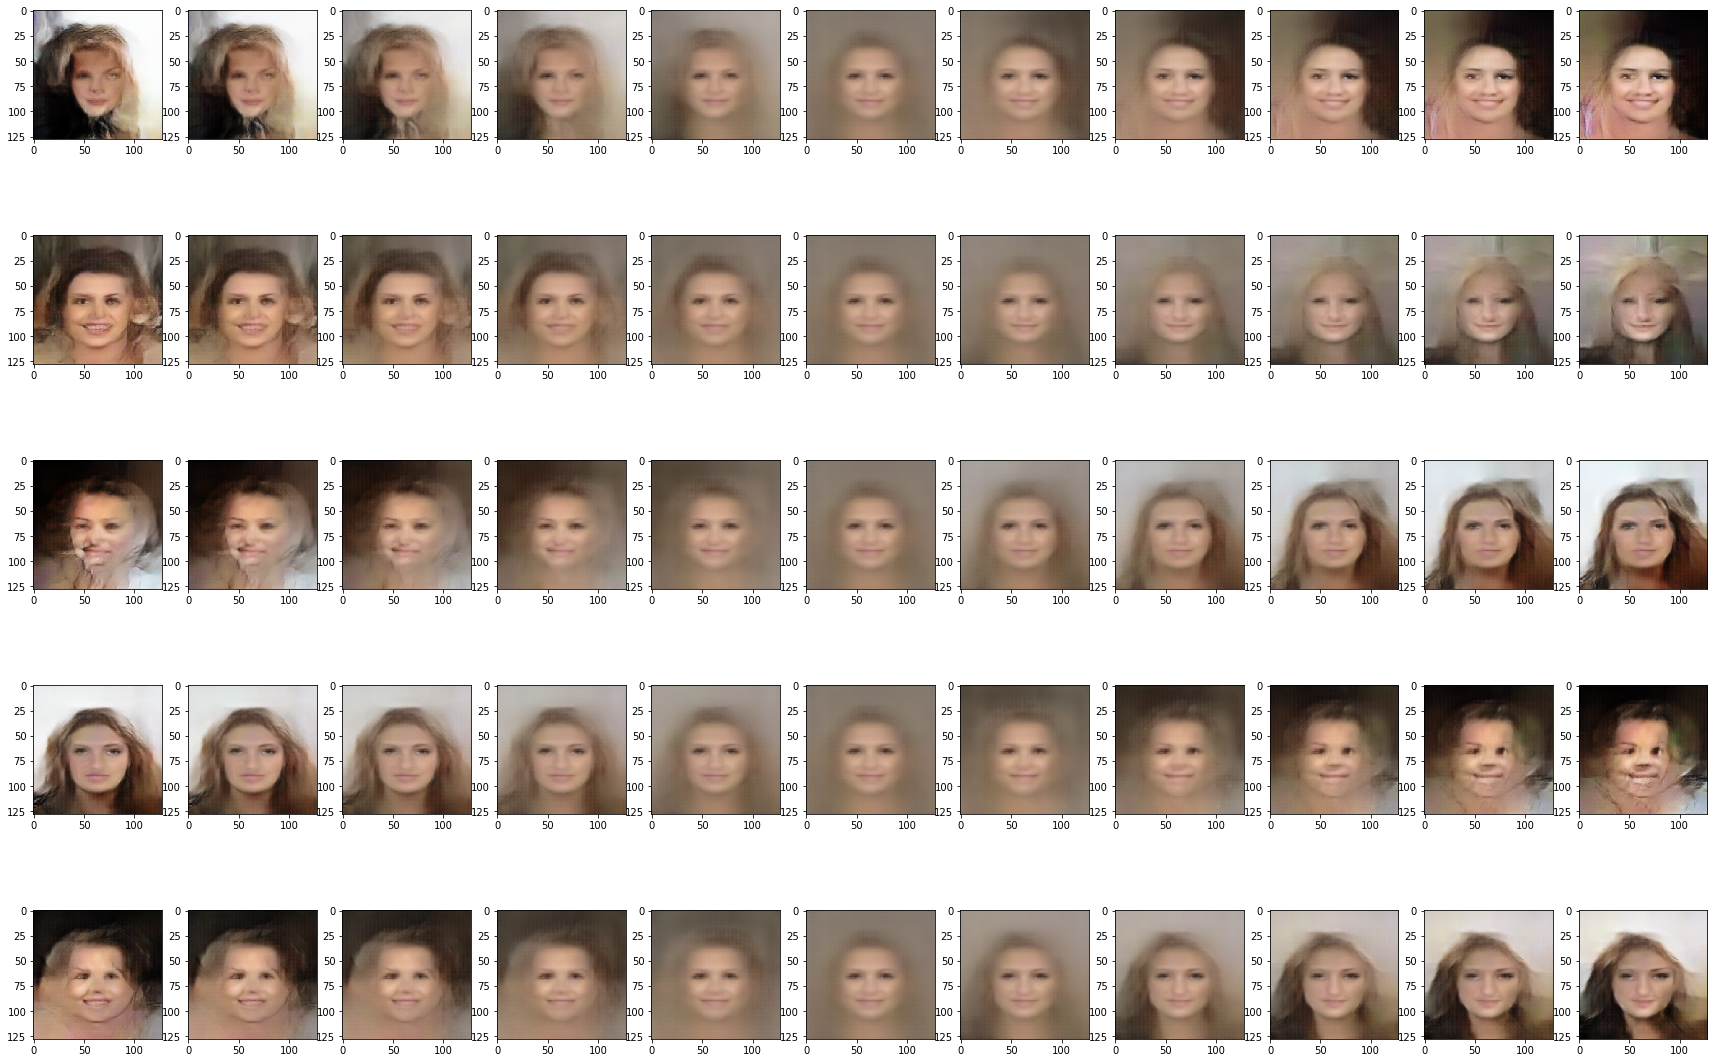

In [20]:
plotComponentsEffect(5, 5, skipfirst = False)